# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [ ]:
! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-12-07 08:19:26,685] Making new env: LunarLander-v2


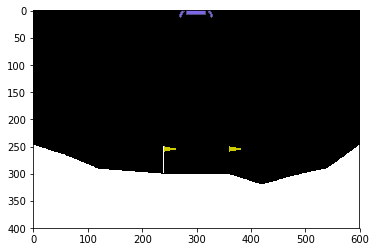

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 100, nonlinearity=elu)
nn = DenseLayer(nn, 200, nonlinearity=elu)
#nn = DenseLayer(nn, 100, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /tmp/try_flags_esm_u4np.c:4:0:\n/usr/include/cudnn.h:63:26: fatal error: driver_types.h: \xd0\x9d\xd0\xb5\xd1\x82 \xd1\x82\xd0\xb0\xd0\xba\xd0\xbe\xd0\xb3\xd0\xbe \xd1\x84\xd0\xb0\xd0\xb9\xd0\xbb\xd0\xb0 \xd0\xb8\xd0\xbb\xd0\xb8 \xd0\xba\xd0\xb0\xd1\x82\xd0\xb0\xd0\xbb\xd0\xbe\xd0\xb3\xd0\xb0\n #include "driver_types.h"\n                          ^\ncompilation terminated.\n'
Mapped name None to device cuda0: GeForce 840M (0000:03:00.0)


Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [6]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-12-07 08:19:34,887] Making new env: LunarLander-v2


In [9]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[3 3 3 3 0]]
rewards: [[-1.96022401 -2.15763381 -2.7906319  -2.8390596   0.        ]]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.13 ms


In [10]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [12]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [13]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [14]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-12-07 08:19:52,079] Making new env: LunarLander-v2
[2017-12-07 08:19:52,084] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:19:52,086] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.0.24307.video000000.mp4
[2017-12-07 08:19:53,706] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 85 timesteps with reward=-794.0368095920812


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [16]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 0

In [17]:
from tqdm import trange

for i in trange(20000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  0%|          | 98/20000 [00:03<11:04, 29.97it/s][2017-12-07 08:20:04,504] Making new env: LunarLander-v2
[2017-12-07 08:20:04,507] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:04,724] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  1%|          | 101/20000 [00:03<11:50, 28.01it/s]

Episode finished after 149 timesteps with reward=-72.77158485462321
Episode finished after 69 timesteps with reward=-189.11749390330277
Episode finished after 150 timesteps with reward=-434.84336201404665
iter=100	epsilon=0.910
Current score(mean over 3) = -232.244


  1%|          | 197/20000 [00:07<11:48, 27.93it/s][2017-12-07 08:20:08,327] Making new env: LunarLander-v2
[2017-12-07 08:20:08,330] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:08,530] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  1%|          | 200/20000 [00:07<12:09, 27.14it/s]

Episode finished after 159 timesteps with reward=-207.07536764293081
Episode finished after 89 timesteps with reward=-323.89597021059126
Episode finished after 93 timesteps with reward=-115.678178655768
iter=200	epsilon=0.828
Current score(mean over 3) = -215.550


  1%|▏         | 299/20000 [00:11<12:17, 26.72it/s][2017-12-07 08:20:12,392] Making new env: LunarLander-v2
[2017-12-07 08:20:12,395] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:12,642] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 202 timesteps with reward=-83.59178686091829
Episode finished after 105 timesteps with reward=-204.46803801799985
Episode finished after 90 timesteps with reward=-294.08424317563185
iter=300	epsilon=0.754
Current score(mean over 3) = -194.048


  2%|▏         | 397/20000 [00:15<12:44, 25.63it/s][2017-12-07 08:20:16,780] Making new env: LunarLander-v2
[2017-12-07 08:20:16,782] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:16,957] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  2%|▏         | 400/20000 [00:15<12:53, 25.32it/s]

Episode finished after 92 timesteps with reward=-404.8841895830127
Episode finished after 82 timesteps with reward=-66.26330388968101
Episode finished after 128 timesteps with reward=-577.2034444137621
iter=400	epsilon=0.687
Current score(mean over 3) = -349.450


  2%|▏         | 497/20000 [00:19<13:04, 24.86it/s][2017-12-07 08:20:21,285] Making new env: LunarLander-v2
[2017-12-07 08:20:21,287] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:21,503] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  2%|▎         | 500/20000 [00:20<13:13, 24.58it/s]

Episode finished after 112 timesteps with reward=-344.16707245629647
Episode finished after 152 timesteps with reward=-167.9772495325618
Episode finished after 109 timesteps with reward=-419.24609803011157
iter=500	epsilon=0.626
Current score(mean over 3) = -310.463


  3%|▎         | 597/20000 [00:25<13:34, 23.83it/s][2017-12-07 08:20:26,354] Making new env: LunarLander-v2
[2017-12-07 08:20:26,356] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:26,539] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  3%|▎         | 600/20000 [00:25<13:40, 23.64it/s]

Episode finished after 158 timesteps with reward=-358.05583551609953
Episode finished after 88 timesteps with reward=-321.9655480916358
Episode finished after 86 timesteps with reward=-374.01159059982575
iter=600	epsilon=0.571
Current score(mean over 3) = -351.344


  3%|▎         | 699/20000 [00:30<13:58, 23.01it/s][2017-12-07 08:20:31,606] Making new env: LunarLander-v2
[2017-12-07 08:20:31,609] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:32,002] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 307 timesteps with reward=-248.54710364271355
Episode finished after 112 timesteps with reward=-269.4036344672626
Episode finished after 132 timesteps with reward=-425.8651588217974
iter=700	epsilon=0.522
Current score(mean over 3) = -314.605


  4%|▍         | 799/20000 [00:36<14:33, 21.99it/s][2017-12-07 08:20:37,565] Making new env: LunarLander-v2
[2017-12-07 08:20:37,568] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:37,819] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 135 timesteps with reward=-371.1477219947476
Episode finished after 121 timesteps with reward=-217.12797126081097
Episode finished after 170 timesteps with reward=-625.8853419769179
iter=800	epsilon=0.477
Current score(mean over 3) = -404.720


  4%|▍         | 899/20000 [00:42<14:59, 21.24it/s][2017-12-07 08:20:43,540] Making new env: LunarLander-v2
[2017-12-07 08:20:43,543] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:43,817] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 160 timesteps with reward=-349.92059905688996
Episode finished after 88 timesteps with reward=-205.4707579951378
Episode finished after 194 timesteps with reward=-613.5523223080905
iter=900	epsilon=0.436
Current score(mean over 3) = -389.648


  5%|▍         | 999/20000 [00:48<15:19, 20.66it/s][2017-12-07 08:20:49,580] Making new env: LunarLander-v2
[2017-12-07 08:20:49,583] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 172 timesteps with reward=-446.873011699066
Episode finished after 105 timesteps with reward=-434.02144517917384


[2017-12-07 08:20:49,912] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  5%|▌         | 1003/20000 [00:48<15:26, 20.49it/s]

Episode finished after 220 timesteps with reward=-567.4563970035834
iter=1000	epsilon=0.399
Current score(mean over 3) = -482.784


  5%|▌         | 1099/20000 [00:54<15:41, 20.08it/s][2017-12-07 08:20:55,943] Making new env: LunarLander-v2
[2017-12-07 08:20:55,945] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:20:56,345] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 287 timesteps with reward=-559.1480059651428
Episode finished after 199 timesteps with reward=-491.28607782556054
Episode finished after 90 timesteps with reward=-357.2616954007648
iter=1100	epsilon=0.366
Current score(mean over 3) = -469.232


  6%|▌         | 1199/20000 [01:01<16:03, 19.52it/s][2017-12-07 08:21:02,660] Making new env: LunarLander-v2
[2017-12-07 08:21:02,662] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:21:02,857] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  6%|▌         | 1201/20000 [01:01<16:06, 19.45it/s]

Episode finished after 116 timesteps with reward=-501.99186604819835
Episode finished after 96 timesteps with reward=-263.77059012108907
Episode finished after 123 timesteps with reward=-573.7931888719825
iter=1200	epsilon=0.336
Current score(mean over 3) = -446.519


  6%|▋         | 1299/20000 [01:07<16:17, 19.14it/s][2017-12-07 08:21:09,092] Making new env: LunarLander-v2
[2017-12-07 08:21:09,095] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 80 timesteps with reward=-233.75166408527295


[2017-12-07 08:21:09,479] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  7%|▋         | 1301/20000 [01:08<16:22, 19.03it/s]

Episode finished after 273 timesteps with reward=-356.93195975728156
Episode finished after 144 timesteps with reward=-339.3476527740497
iter=1300	epsilon=0.309
Current score(mean over 3) = -310.010


  7%|▋         | 1399/20000 [01:14<16:36, 18.67it/s][2017-12-07 08:21:16,177] Making new env: LunarLander-v2
[2017-12-07 08:21:16,180] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:21:16,584] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 286 timesteps with reward=-935.0953688714102
Episode finished after 196 timesteps with reward=-361.7964940874646
Episode finished after 76 timesteps with reward=-392.98035440950014
iter=1400	epsilon=0.284
Current score(mean over 3) = -563.291


  7%|▋         | 1499/20000 [01:23<17:07, 18.01it/s][2017-12-07 08:21:24,459] Making new env: LunarLander-v2
[2017-12-07 08:21:24,462] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 134 timesteps with reward=-207.89242649577662
Episode finished after 200 timesteps with reward=-310.5773529737765


[2017-12-07 08:21:24,790] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  8%|▊         | 1501/20000 [01:23<17:11, 17.93it/s]

Episode finished after 160 timesteps with reward=-532.3800899813774
iter=1500	epsilon=0.262
Current score(mean over 3) = -350.283


  8%|▊         | 1598/20000 [01:32<17:40, 17.36it/s][2017-12-07 08:21:33,383] Making new env: LunarLander-v2
[2017-12-07 08:21:33,386] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 125 timesteps with reward=-262.95965632368336
Episode finished after 256 timesteps with reward=-816.9807538489188


[2017-12-07 08:21:33,908] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  8%|▊         | 1602/20000 [01:32<17:47, 17.24it/s]

Episode finished after 294 timesteps with reward=-797.1114674537675
iter=1600	epsilon=0.242
Current score(mean over 3) = -625.684


  8%|▊         | 1698/20000 [01:40<18:07, 16.82it/s][2017-12-07 08:21:42,251] Making new env: LunarLander-v2
[2017-12-07 08:21:42,253] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 236 timesteps with reward=-242.56433295263489
Episode finished after 195 timesteps with reward=-220.17808535236958


[2017-12-07 08:21:42,707] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  9%|▊         | 1702/20000 [01:41<18:13, 16.73it/s]

Episode finished after 203 timesteps with reward=-221.0811096408935
iter=1700	epsilon=0.224
Current score(mean over 3) = -227.941


  9%|▉         | 1798/20000 [01:49<18:30, 16.38it/s][2017-12-07 08:21:51,058] Making new env: LunarLander-v2
[2017-12-07 08:21:51,060] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 261 timesteps with reward=-247.2370604861935
Episode finished after 93 timesteps with reward=-211.24146856135803


[2017-12-07 08:21:51,583] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
  9%|▉         | 1802/20000 [01:50<18:36, 16.29it/s]

Episode finished after 346 timesteps with reward=-406.76535176961215
iter=1800	epsilon=0.207
Current score(mean over 3) = -288.415


  9%|▉         | 1898/20000 [01:59<18:58, 15.90it/s][2017-12-07 08:22:00,703] Making new env: LunarLander-v2
[2017-12-07 08:22:00,706] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:22:00,975] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 10%|▉         | 1900/20000 [01:59<19:01, 15.86it/s]

Episode finished after 111 timesteps with reward=-176.34466635720227
Episode finished after 125 timesteps with reward=-280.7898588718141
Episode finished after 193 timesteps with reward=-257.7248175710823
iter=1900	epsilon=0.192
Current score(mean over 3) = -238.286


 10%|▉         | 1999/20000 [02:10<19:39, 15.26it/s][2017-12-07 08:22:12,340] Making new env: LunarLander-v2
[2017-12-07 08:22:12,343] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-244.93878697231472
Episode finished after 1000 timesteps with reward=-252.09444564632847


[2017-12-07 08:22:16,434] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 10%|█         | 2000/20000 [02:15<20:17, 14.79it/s]

Episode finished after 403 timesteps with reward=-412.86136990547004
iter=2000	epsilon=0.179
Current score(mean over 3) = -303.298


 10%|█         | 2098/20000 [02:25<20:42, 14.41it/s][2017-12-07 08:22:27,006] Making new env: LunarLander-v2
[2017-12-07 08:22:27,008] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 270 timesteps with reward=-254.57249053788067
Episode finished after 223 timesteps with reward=-259.68548272895976


[2017-12-07 08:22:27,696] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 11%|█         | 2101/20000 [02:26<20:49, 14.33it/s]

Episode finished after 322 timesteps with reward=-399.14937369924036
iter=2100	epsilon=0.166
Current score(mean over 3) = -304.469


 11%|█         | 2199/20000 [02:39<21:32, 13.77it/s][2017-12-07 08:22:41,004] Making new env: LunarLander-v2
[2017-12-07 08:22:41,006] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 660 timesteps with reward=-366.7801873757244
Episode finished after 112 timesteps with reward=-196.0855236010287


[2017-12-07 08:22:42,736] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 11%|█         | 2201/20000 [02:41<21:47, 13.61it/s]

Episode finished after 573 timesteps with reward=-460.70229119730067
iter=2200	epsilon=0.155
Current score(mean over 3) = -341.189


 11%|█▏        | 2299/20000 [02:53<22:19, 13.22it/s][2017-12-07 08:22:55,218] Making new env: LunarLander-v2
[2017-12-07 08:22:55,221] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 538 timesteps with reward=-209.66428160026436
Episode finished after 425 timesteps with reward=-228.12751595766636


[2017-12-07 08:22:56,533] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 12%|█▏        | 2302/20000 [02:55<22:29, 13.11it/s]

Episode finished after 325 timesteps with reward=-339.0158953226311
iter=2300	epsilon=0.145
Current score(mean over 3) = -258.936


 12%|█▏        | 2399/20000 [03:08<23:01, 12.74it/s][2017-12-07 08:23:09,549] Making new env: LunarLander-v2
[2017-12-07 08:23:09,552] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-217.14721033739403
Episode finished after 1000 timesteps with reward=-222.79749383706454


[2017-12-07 08:23:12,878] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 12%|█▏        | 2401/20000 [03:11<23:26, 12.51it/s]

Episode finished after 544 timesteps with reward=-266.2701347010195
iter=2400	epsilon=0.136
Current score(mean over 3) = -235.405


 12%|█▏        | 2499/20000 [03:24<23:49, 12.25it/s][2017-12-07 08:23:25,364] Making new env: LunarLander-v2
[2017-12-07 08:23:25,366] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-233.12118069632584
Episode finished after 148 timesteps with reward=-217.0581330418087


[2017-12-07 08:23:29,093] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 13%|█▎        | 2501/20000 [03:28<24:15, 12.02it/s]

Episode finished after 1000 timesteps with reward=-221.01446248305
iter=2500	epsilon=0.128
Current score(mean over 3) = -223.731


 13%|█▎        | 2599/20000 [03:41<24:42, 11.73it/s][2017-12-07 08:23:42,787] Making new env: LunarLander-v2
[2017-12-07 08:23:42,789] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 737 timesteps with reward=-279.80279668649257
Episode finished after 1000 timesteps with reward=-218.2850718293988


[2017-12-07 08:23:45,911] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 13%|█▎        | 2601/20000 [03:44<25:04, 11.57it/s]

Episode finished after 429 timesteps with reward=-290.49254027105985
iter=2600	epsilon=0.121
Current score(mean over 3) = -262.860


 13%|█▎        | 2699/20000 [03:59<25:33, 11.28it/s][2017-12-07 08:24:00,615] Making new env: LunarLander-v2
[2017-12-07 08:24:00,618] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-206.4735626667302


[2017-12-07 08:24:02,652] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 14%|█▎        | 2700/20000 [04:01<25:47, 11.18it/s]

Episode finished after 284 timesteps with reward=-406.1234794761496
Episode finished after 245 timesteps with reward=-184.58114728815158
iter=2700	epsilon=0.114
Current score(mean over 3) = -265.726


 14%|█▍        | 2799/20000 [04:15<26:11, 10.94it/s][2017-12-07 08:24:17,066] Making new env: LunarLander-v2
[2017-12-07 08:24:17,068] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 107 timesteps with reward=-348.93158282354665
Episode finished after 474 timesteps with reward=-175.84660745987586


[2017-12-07 08:24:19,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 14%|█▍        | 2801/20000 [04:18<26:27, 10.83it/s]

Episode finished after 1000 timesteps with reward=-195.75194851716364
iter=2800	epsilon=0.108
Current score(mean over 3) = -240.177


 14%|█▍        | 2899/20000 [04:29<26:30, 10.75it/s][2017-12-07 08:24:30,883] Making new env: LunarLander-v2
[2017-12-07 08:24:30,885] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 369 timesteps with reward=-320.85288971259695


[2017-12-07 08:24:32,327] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 14%|█▍        | 2900/20000 [04:31<26:38, 10.69it/s]

Episode finished after 643 timesteps with reward=-531.1178012191394
Episode finished after 235 timesteps with reward=-360.11492027216343
iter=2900	epsilon=0.102
Current score(mean over 3) = -404.029


 15%|█▍        | 2999/20000 [04:42<26:41, 10.62it/s][2017-12-07 08:24:43,823] Making new env: LunarLander-v2
[2017-12-07 08:24:43,825] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 425 timesteps with reward=-210.2703945434477


[2017-12-07 08:24:44,952] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 15%|█▌        | 3000/20000 [04:43<26:48, 10.57it/s]

Episode finished after 521 timesteps with reward=-291.7110406343015
Episode finished after 161 timesteps with reward=-434.69233357082385
iter=3000	epsilon=0.097
Current score(mean over 3) = -312.225


 15%|█▌        | 3099/20000 [04:54<26:46, 10.52it/s][2017-12-07 08:24:55,935] Making new env: LunarLander-v2
[2017-12-07 08:24:55,937] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 162 timesteps with reward=-442.1731418956077


[2017-12-07 08:24:56,433] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 16%|█▌        | 3100/20000 [04:55<26:49, 10.50it/s]

Episode finished after 282 timesteps with reward=-310.45837486350865
Episode finished after 209 timesteps with reward=-534.3084803466345
iter=3100	epsilon=0.093
Current score(mean over 3) = -428.980


 16%|█▌        | 3199/20000 [05:06<26:50, 10.43it/s][2017-12-07 08:25:07,866] Making new env: LunarLander-v2
[2017-12-07 08:25:07,868] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 262 timesteps with reward=-371.99076250883724
Episode finished after 286 timesteps with reward=-471.0948439508371


[2017-12-07 08:25:08,861] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 16%|█▌        | 3201/20000 [05:07<26:55, 10.40it/s]

Episode finished after 185 timesteps with reward=-199.11928695395216
iter=3200	epsilon=0.089
Current score(mean over 3) = -347.402


 16%|█▋        | 3299/20000 [05:17<26:47, 10.39it/s][2017-12-07 08:25:18,705] Making new env: LunarLander-v2
[2017-12-07 08:25:18,707] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 226 timesteps with reward=-502.6441117852803
Episode finished after 220 timesteps with reward=-504.55997488127343


[2017-12-07 08:25:19,140] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 17%|█▋        | 3301/20000 [05:18<26:49, 10.38it/s]

Episode finished after 199 timesteps with reward=-520.0158517530979
iter=3300	epsilon=0.085
Current score(mean over 3) = -509.073


 17%|█▋        | 3398/20000 [05:26<26:34, 10.41it/s][2017-12-07 08:25:27,670] Making new env: LunarLander-v2
[2017-12-07 08:25:27,672] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 247 timesteps with reward=-397.34199290164753
Episode finished after 270 timesteps with reward=-598.2325933644031


[2017-12-07 08:25:28,199] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 17%|█▋        | 3402/20000 [05:27<26:36, 10.40it/s]

Episode finished after 211 timesteps with reward=-552.962548003131
iter=3400	epsilon=0.082
Current score(mean over 3) = -516.179


 17%|█▋        | 3498/20000 [05:35<26:23, 10.42it/s][2017-12-07 08:25:36,959] Making new env: LunarLander-v2
[2017-12-07 08:25:36,962] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 178 timesteps with reward=-327.00494628922644
Episode finished after 211 timesteps with reward=-508.1117254638464


[2017-12-07 08:25:37,322] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 18%|█▊        | 3502/20000 [05:36<26:24, 10.41it/s]

Episode finished after 144 timesteps with reward=-83.44341875104988
iter=3500	epsilon=0.079
Current score(mean over 3) = -306.187


 18%|█▊        | 3598/20000 [05:44<26:10, 10.45it/s][2017-12-07 08:25:45,762] Making new env: LunarLander-v2
[2017-12-07 08:25:45,764] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 264 timesteps with reward=-406.98048072812315
Episode finished after 158 timesteps with reward=-316.4250192809967


[2017-12-07 08:25:46,212] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 18%|█▊        | 3601/20000 [05:45<26:11, 10.43it/s]

Episode finished after 191 timesteps with reward=-157.34441993436977
iter=3600	epsilon=0.076
Current score(mean over 3) = -293.583


 18%|█▊        | 3699/20000 [05:53<25:57, 10.46it/s][2017-12-07 08:25:54,748] Making new env: LunarLander-v2
[2017-12-07 08:25:54,750] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:25:55,145] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 260 timesteps with reward=-454.3095944886711
Episode finished after 138 timesteps with reward=-10.337339041744627
Episode finished after 163 timesteps with reward=-343.35155514116434
iter=3700	epsilon=0.073
Current score(mean over 3) = -269.333


 19%|█▉        | 3798/20000 [06:02<25:46, 10.48it/s][2017-12-07 08:26:03,813] Making new env: LunarLander-v2
[2017-12-07 08:26:03,816] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 184 timesteps with reward=-246.24802640183114
Episode finished after 181 timesteps with reward=-742.4889934982739


[2017-12-07 08:26:04,304] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 19%|█▉        | 3802/20000 [06:03<25:47, 10.46it/s]

Episode finished after 293 timesteps with reward=-387.12390069801
iter=3800	epsilon=0.071
Current score(mean over 3) = -458.620


 19%|█▉        | 3898/20000 [06:11<25:33, 10.50it/s][2017-12-07 08:26:12,596] Making new env: LunarLander-v2
[2017-12-07 08:26:12,599] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 119 timesteps with reward=-255.8480512769282
Episode finished after 164 timesteps with reward=-690.011480737015


[2017-12-07 08:26:12,919] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 20%|█▉        | 3902/20000 [06:11<25:34, 10.49it/s]

Episode finished after 221 timesteps with reward=-629.2839396510439
iter=3900	epsilon=0.069
Current score(mean over 3) = -525.048


 20%|█▉        | 3998/20000 [06:19<25:19, 10.53it/s][2017-12-07 08:26:20,926] Making new env: LunarLander-v2
[2017-12-07 08:26:20,928] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 159 timesteps with reward=-352.8453465061263
Episode finished after 203 timesteps with reward=-155.32029524185288


[2017-12-07 08:26:21,297] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 20%|██        | 4002/20000 [06:20<25:20, 10.52it/s]

Episode finished after 189 timesteps with reward=-584.5964193479388
iter=4000	epsilon=0.067
Current score(mean over 3) = -364.254


 20%|██        | 4098/20000 [06:28<25:07, 10.55it/s][2017-12-07 08:26:29,724] Making new env: LunarLander-v2
[2017-12-07 08:26:29,727] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 231 timesteps with reward=-289.0011817762057
Episode finished after 169 timesteps with reward=-480.1082792837165


[2017-12-07 08:26:30,142] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 21%|██        | 4102/20000 [06:29<25:08, 10.54it/s]

Episode finished after 207 timesteps with reward=-97.99682658201802
iter=4100	epsilon=0.066
Current score(mean over 3) = -289.035


 21%|██        | 4199/20000 [06:37<24:55, 10.56it/s][2017-12-07 08:26:38,689] Making new env: LunarLander-v2
[2017-12-07 08:26:38,692] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 154 timesteps with reward=-223.39040720189263
Episode finished after 179 timesteps with reward=-317.5461247717031


[2017-12-07 08:26:39,034] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 21%|██        | 4201/20000 [06:37<24:56, 10.56it/s]

Episode finished after 179 timesteps with reward=-155.97761067760408
iter=4200	epsilon=0.064
Current score(mean over 3) = -232.305


 21%|██▏       | 4299/20000 [06:46<24:44, 10.58it/s][2017-12-07 08:26:47,600] Making new env: LunarLander-v2
[2017-12-07 08:26:47,603] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 276 timesteps with reward=-185.184192913297
Episode finished after 189 timesteps with reward=-261.95783794564795


[2017-12-07 08:26:48,098] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 22%|██▏       | 4301/20000 [06:47<24:45, 10.57it/s]

Episode finished after 185 timesteps with reward=-215.00203126070988
iter=4300	epsilon=0.063
Current score(mean over 3) = -220.715


 22%|██▏       | 4399/20000 [06:55<24:32, 10.60it/s][2017-12-07 08:26:56,353] Making new env: LunarLander-v2
[2017-12-07 08:26:56,355] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 228 timesteps with reward=-370.1643079793901
Episode finished after 202 timesteps with reward=-1160.9697543978134


[2017-12-07 08:26:56,749] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 22%|██▏       | 4401/20000 [06:55<24:33, 10.59it/s]

Episode finished after 131 timesteps with reward=-992.858134217847
iter=4400	epsilon=0.062
Current score(mean over 3) = -841.331


 22%|██▏       | 4499/20000 [07:04<24:21, 10.61it/s][2017-12-07 08:27:05,460] Making new env: LunarLander-v2
[2017-12-07 08:27:05,463] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 252 timesteps with reward=-380.0882025524222
Episode finished after 229 timesteps with reward=-421.74892920464254


[2017-12-07 08:27:05,966] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 23%|██▎       | 4501/20000 [07:04<24:23, 10.59it/s]

Episode finished after 212 timesteps with reward=-423.61541781652505
iter=4500	epsilon=0.061
Current score(mean over 3) = -408.484


 23%|██▎       | 4599/20000 [07:13<24:11, 10.61it/s][2017-12-07 08:27:14,633] Making new env: LunarLander-v2
[2017-12-07 08:27:14,635] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 139 timesteps with reward=-280.5229580862596
Episode finished after 172 timesteps with reward=-328.8276604629758


[2017-12-07 08:27:14,998] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 23%|██▎       | 4601/20000 [07:13<24:12, 10.60it/s]

Episode finished after 235 timesteps with reward=-409.0272953724426
iter=4600	epsilon=0.060
Current score(mean over 3) = -339.459


 23%|██▎       | 4698/20000 [07:22<24:00, 10.62it/s][2017-12-07 08:27:23,521] Making new env: LunarLander-v2
[2017-12-07 08:27:23,524] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 210 timesteps with reward=-318.17342682484446
Episode finished after 296 timesteps with reward=-362.44055019835275


[2017-12-07 08:27:24,150] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 24%|██▎       | 4702/20000 [07:23<24:01, 10.61it/s]

Episode finished after 289 timesteps with reward=-482.5253066483089
iter=4700	epsilon=0.059
Current score(mean over 3) = -387.713


 24%|██▍       | 4798/20000 [07:31<23:49, 10.63it/s][2017-12-07 08:27:32,511] Making new env: LunarLander-v2
[2017-12-07 08:27:32,514] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 159 timesteps with reward=-350.49707650096576
Episode finished after 222 timesteps with reward=-399.55365602669247


[2017-12-07 08:27:32,970] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 24%|██▍       | 4802/20000 [07:31<23:50, 10.62it/s]

Episode finished after 245 timesteps with reward=-420.6128083504087
iter=4800	epsilon=0.058
Current score(mean over 3) = -390.221


 24%|██▍       | 4898/20000 [07:40<23:38, 10.65it/s][2017-12-07 08:27:41,363] Making new env: LunarLander-v2
[2017-12-07 08:27:41,365] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 216 timesteps with reward=-298.19494096294943


[2017-12-07 08:27:41,916] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 24%|██▍       | 4900/20000 [07:40<23:39, 10.63it/s]

Episode finished after 270 timesteps with reward=-509.35656077160684
Episode finished after 238 timesteps with reward=-399.5358101240437
iter=4900	epsilon=0.057
Current score(mean over 3) = -402.362


 25%|██▍       | 4999/20000 [07:49<23:28, 10.65it/s][2017-12-07 08:27:50,592] Making new env: LunarLander-v2
[2017-12-07 08:27:50,595] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 200 timesteps with reward=-340.06823413223276
Episode finished after 251 timesteps with reward=-364.55304590838114


[2017-12-07 08:27:51,047] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 25%|██▌       | 5001/20000 [07:49<23:29, 10.64it/s]

Episode finished after 216 timesteps with reward=-327.76775383606207
iter=5000	epsilon=0.056
Current score(mean over 3) = -344.130


 25%|██▌       | 5099/20000 [07:58<23:18, 10.66it/s][2017-12-07 08:27:59,830] Making new env: LunarLander-v2
[2017-12-07 08:27:59,832] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 172 timesteps with reward=-178.86951972304257
Episode finished after 256 timesteps with reward=-194.9643507750153


[2017-12-07 08:28:00,454] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 26%|██▌       | 5101/20000 [07:59<23:20, 10.64it/s]

Episode finished after 354 timesteps with reward=-314.66973860272606
iter=5100	epsilon=0.056
Current score(mean over 3) = -229.501


 26%|██▌       | 5198/20000 [08:08<23:10, 10.65it/s][2017-12-07 08:28:09,516] Making new env: LunarLander-v2
[2017-12-07 08:28:09,519] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 301 timesteps with reward=-345.8648787667132
Episode finished after 261 timesteps with reward=-273.30934155782904


[2017-12-07 08:28:10,309] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 26%|██▌       | 5201/20000 [08:09<23:12, 10.63it/s]

Episode finished after 347 timesteps with reward=-337.02557529015246
iter=5200	epsilon=0.055
Current score(mean over 3) = -318.733


 26%|██▋       | 5299/20000 [08:17<23:00, 10.65it/s][2017-12-07 08:28:18,892] Making new env: LunarLander-v2
[2017-12-07 08:28:18,894] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 185 timesteps with reward=-210.9186275922505
Episode finished after 206 timesteps with reward=-270.34278498807726


[2017-12-07 08:28:19,272] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 27%|██▋       | 5301/20000 [08:18<23:01, 10.64it/s]

Episode finished after 181 timesteps with reward=-269.2635298654902
iter=5300	epsilon=0.055
Current score(mean over 3) = -250.175


 27%|██▋       | 5399/20000 [08:26<22:49, 10.66it/s][2017-12-07 08:28:27,581] Making new env: LunarLander-v2
[2017-12-07 08:28:27,584] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 94 timesteps with reward=-332.0977008403955
Episode finished after 191 timesteps with reward=-401.46244045916956


[2017-12-07 08:28:27,960] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 27%|██▋       | 5401/20000 [08:26<22:50, 10.66it/s]

Episode finished after 254 timesteps with reward=-314.4590897938607
iter=5400	epsilon=0.054
Current score(mean over 3) = -349.340


 27%|██▋       | 5499/20000 [08:35<22:39, 10.67it/s][2017-12-07 08:28:36,797] Making new env: LunarLander-v2
[2017-12-07 08:28:36,799] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 260 timesteps with reward=-173.81892673961653
Episode finished after 296 timesteps with reward=-357.7775235439778


[2017-12-07 08:28:37,657] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 28%|██▊       | 5501/20000 [08:36<22:41, 10.65it/s]

Episode finished after 389 timesteps with reward=-372.0262862579798
iter=5500	epsilon=0.054
Current score(mean over 3) = -301.208


 28%|██▊       | 5599/20000 [08:44<22:30, 10.67it/s][2017-12-07 08:28:46,229] Making new env: LunarLander-v2
[2017-12-07 08:28:46,231] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 237 timesteps with reward=-73.01217635795518
Episode finished after 150 timesteps with reward=-254.6221442413383


[2017-12-07 08:28:46,641] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 28%|██▊       | 5601/20000 [08:45<22:31, 10.66it/s]

Episode finished after 206 timesteps with reward=-228.10794924596195
iter=5600	epsilon=0.054
Current score(mean over 3) = -185.247


 28%|██▊       | 5699/20000 [08:54<22:20, 10.67it/s][2017-12-07 08:28:55,262] Making new env: LunarLander-v2
[2017-12-07 08:28:55,264] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 128 timesteps with reward=-221.45764250096352
Episode finished after 234 timesteps with reward=-305.68289280854594


[2017-12-07 08:28:55,612] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 29%|██▊       | 5701/20000 [08:54<22:20, 10.67it/s]

Episode finished after 160 timesteps with reward=-321.90044422075084
iter=5700	epsilon=0.053
Current score(mean over 3) = -283.014


 29%|██▉       | 5799/20000 [09:02<22:09, 10.68it/s][2017-12-07 08:29:04,104] Making new env: LunarLander-v2
[2017-12-07 08:29:04,107] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:29:04,285] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 29%|██▉       | 5801/20000 [09:03<22:09, 10.68it/s]

Episode finished after 109 timesteps with reward=-94.2647145973309
Episode finished after 101 timesteps with reward=-136.91670214448385
Episode finished after 96 timesteps with reward=-126.29270799113958
iter=5800	epsilon=0.053
Current score(mean over 3) = -119.158


 29%|██▉       | 5899/20000 [09:11<21:57, 10.70it/s][2017-12-07 08:29:12,509] Making new env: LunarLander-v2
[2017-12-07 08:29:12,511] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:29:12,717] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 30%|██▉       | 5901/20000 [09:11<21:58, 10.70it/s]

Episode finished after 173 timesteps with reward=-124.02561468170089
Episode finished after 92 timesteps with reward=-501.4954561789045
Episode finished after 82 timesteps with reward=-527.5564068193885
iter=5900	epsilon=0.053
Current score(mean over 3) = -384.359


 30%|██▉       | 5999/20000 [09:19<21:45, 10.72it/s][2017-12-07 08:29:20,767] Making new env: LunarLander-v2
[2017-12-07 08:29:20,769] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:29:20,929] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 30%|███       | 6001/20000 [09:19<21:46, 10.72it/s]

Episode finished after 92 timesteps with reward=-445.24720229404494
Episode finished after 112 timesteps with reward=-74.69100460877323
Episode finished after 74 timesteps with reward=-648.2124135404108
iter=6000	epsilon=0.052
Current score(mean over 3) = -389.384


 30%|███       | 6098/20000 [09:28<21:36, 10.72it/s][2017-12-07 08:29:30,156] Making new env: LunarLander-v2
[2017-12-07 08:29:30,159] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:29:30,352] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 30%|███       | 6100/20000 [09:29<21:37, 10.72it/s]

Episode finished after 84 timesteps with reward=-459.5135756238749
Episode finished after 124 timesteps with reward=-83.53167892752555
Episode finished after 115 timesteps with reward=-450.1291701073184
iter=6100	epsilon=0.052
Current score(mean over 3) = -331.058


 31%|███       | 6198/20000 [09:36<21:24, 10.74it/s][2017-12-07 08:29:38,311] Making new env: LunarLander-v2
[2017-12-07 08:29:38,314] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:29:38,494] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 31%|███       | 6200/20000 [09:37<21:25, 10.74it/s]

Episode finished after 70 timesteps with reward=-567.9051340728982
Episode finished after 144 timesteps with reward=-494.5314914298849
Episode finished after 95 timesteps with reward=-127.33890742882994
iter=6200	epsilon=0.052
Current score(mean over 3) = -396.592


 31%|███▏      | 6298/20000 [09:45<21:13, 10.76it/s][2017-12-07 08:29:46,470] Making new env: LunarLander-v2
[2017-12-07 08:29:46,473] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:29:46,708] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 32%|███▏      | 6300/20000 [09:45<21:13, 10.76it/s]

Episode finished after 93 timesteps with reward=-274.7825337113568
Episode finished after 91 timesteps with reward=-492.94055716342785
Episode finished after 198 timesteps with reward=-370.2339310602617
iter=6300	epsilon=0.052
Current score(mean over 3) = -379.319


 32%|███▏      | 6398/20000 [09:53<21:01, 10.78it/s][2017-12-07 08:29:54,871] Making new env: LunarLander-v2
[2017-12-07 08:29:54,873] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:29:55,138] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 32%|███▏      | 6400/20000 [09:53<21:02, 10.77it/s]

Episode finished after 137 timesteps with reward=-324.8404765223755
Episode finished after 132 timesteps with reward=-59.93255231304164
Episode finished after 156 timesteps with reward=-176.72585365779548
iter=6400	epsilon=0.052
Current score(mean over 3) = -187.166


 32%|███▏      | 6498/20000 [10:02<20:51, 10.79it/s][2017-12-07 08:30:03,674] Making new env: LunarLander-v2
[2017-12-07 08:30:03,676] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 188 timesteps with reward=-345.46889912026234
Episode finished after 113 timesteps with reward=-121.62263111475806


[2017-12-07 08:30:04,067] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 33%|███▎      | 6502/20000 [10:03<20:51, 10.78it/s]

Episode finished after 247 timesteps with reward=-201.59020264519927
iter=6500	epsilon=0.051
Current score(mean over 3) = -222.894


 33%|███▎      | 6598/20000 [10:10<20:40, 10.80it/s][2017-12-07 08:30:12,278] Making new env: LunarLander-v2
[2017-12-07 08:30:12,281] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 166 timesteps with reward=-370.265725397046
Episode finished after 187 timesteps with reward=-264.54668760210626


[2017-12-07 08:30:12,648] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 33%|███▎      | 6602/20000 [10:11<20:41, 10.79it/s]

Episode finished after 191 timesteps with reward=-217.55275916595673
iter=6600	epsilon=0.051
Current score(mean over 3) = -284.122


 33%|███▎      | 6698/20000 [10:19<20:30, 10.81it/s][2017-12-07 08:30:20,714] Making new env: LunarLander-v2
[2017-12-07 08:30:20,717] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:30:20,989] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 34%|███▎      | 6700/20000 [10:19<20:30, 10.81it/s]

Episode finished after 215 timesteps with reward=-302.2362364732523
Episode finished after 103 timesteps with reward=-324.975174654487
Episode finished after 135 timesteps with reward=-261.93912563929314
iter=6700	epsilon=0.051
Current score(mean over 3) = -296.384


 34%|███▍      | 6798/20000 [10:27<20:18, 10.83it/s][2017-12-07 08:30:28,969] Making new env: LunarLander-v2
[2017-12-07 08:30:28,971] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 193 timesteps with reward=-110.83891677091725
Episode finished after 191 timesteps with reward=-392.8904320890942


[2017-12-07 08:30:29,458] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 34%|███▍      | 6802/20000 [10:28<20:19, 10.82it/s]

Episode finished after 275 timesteps with reward=-314.0593933963986
iter=6800	epsilon=0.051
Current score(mean over 3) = -272.596


 34%|███▍      | 6898/20000 [10:36<20:08, 10.84it/s][2017-12-07 08:30:37,739] Making new env: LunarLander-v2
[2017-12-07 08:30:37,742] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:30:37,995] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 34%|███▍      | 6900/20000 [10:36<20:09, 10.83it/s]

Episode finished after 99 timesteps with reward=-265.20650787116534
Episode finished after 151 timesteps with reward=-328.37296731764263
Episode finished after 153 timesteps with reward=-259.2663224142548
iter=6900	epsilon=0.051
Current score(mean over 3) = -284.282


 35%|███▍      | 6998/20000 [10:44<19:57, 10.86it/s][2017-12-07 08:30:45,991] Making new env: LunarLander-v2
[2017-12-07 08:30:45,994] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:30:46,246] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 35%|███▌      | 7000/20000 [10:45<19:58, 10.85it/s]

Episode finished after 127 timesteps with reward=-442.32239829989305
Episode finished after 160 timesteps with reward=-156.1327342961415
Episode finished after 119 timesteps with reward=-131.36249500335362
iter=7000	epsilon=0.051
Current score(mean over 3) = -243.273


 35%|███▌      | 7098/20000 [10:52<19:46, 10.87it/s][2017-12-07 08:30:54,250] Making new env: LunarLander-v2
[2017-12-07 08:30:54,252] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:30:54,551] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 160 timesteps with reward=-378.6616922079358
Episode finished after 164 timesteps with reward=-124.71705049744995
Episode finished after 157 timesteps with reward=-225.30177594953165
iter=7100	epsilon=0.051
Current score(mean over 3) = -242.894

 36%|███▌      | 7198/20000 [11:01<19:36, 10.89it/s][2017-12-07 08:31:02,576] Making new env: LunarLander-v2
[2017-12-07 08:31:02,579] Clearing 2 monitor files from previous run (because force=True was provided)



Episode finished after 167 timesteps with reward=-529.1348850274043
Episode finished after 219 timesteps with reward=-260.29801232947693


[2017-12-07 08:31:02,933] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 36%|███▌      | 7202/20000 [11:01<19:36, 10.88it/s]

Episode finished after 144 timesteps with reward=-343.5982381939439
iter=7200	epsilon=0.051
Current score(mean over 3) = -377.677


 36%|███▋      | 7298/20000 [11:09<19:25, 10.90it/s][2017-12-07 08:31:11,129] Making new env: LunarLander-v2
[2017-12-07 08:31:11,131] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 08:31:11,439] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 36%|███▋      | 7300/20000 [11:10<19:26, 10.89it/s]

Episode finished after 171 timesteps with reward=-243.64278183362393
Episode finished after 202 timesteps with reward=-291.58139814769834
Episode finished after 119 timesteps with reward=-104.71630024030767
iter=7300	epsilon=0.051
Current score(mean over 3) = -213.313


 37%|███▋      | 7398/20000 [11:18<19:16, 10.90it/s][2017-12-07 08:31:20,322] Making new env: LunarLander-v2
[2017-12-07 08:31:20,325] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 212 timesteps with reward=-205.7160074869562
Episode finished after 205 timesteps with reward=-284.54658214768057


[2017-12-07 08:31:20,891] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 37%|███▋      | 7402/20000 [11:19<19:17, 10.89it/s]

Episode finished after 223 timesteps with reward=-128.62305381961312
iter=7400	epsilon=0.051
Current score(mean over 3) = -206.295


 37%|███▋      | 7499/20000 [11:31<19:12, 10.85it/s][2017-12-07 08:31:32,702] Making new env: LunarLander-v2
[2017-12-07 08:31:32,705] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 252 timesteps with reward=-229.4773858680496
Episode finished after 251 timesteps with reward=-333.4396194755944


[2017-12-07 08:31:33,284] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 38%|███▊      | 7501/20000 [11:32<19:13, 10.84it/s]

Episode finished after 205 timesteps with reward=-219.11787171332998
iter=7500	epsilon=0.051
Current score(mean over 3) = -260.678


 38%|███▊      | 7599/20000 [11:42<19:05, 10.82it/s][2017-12-07 08:31:43,419] Making new env: LunarLander-v2
[2017-12-07 08:31:43,421] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 287 timesteps with reward=-233.48909399380022
Episode finished after 176 timesteps with reward=-133.73682450552164


[2017-12-07 08:31:43,984] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 38%|███▊      | 7601/20000 [11:42<19:06, 10.81it/s]

Episode finished after 151 timesteps with reward=-47.835333074134496
iter=7600	epsilon=0.050
Current score(mean over 3) = -138.354


 38%|███▊      | 7699/20000 [11:53<19:00, 10.79it/s][2017-12-07 08:31:54,854] Making new env: LunarLander-v2
[2017-12-07 08:31:54,857] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 126 timesteps with reward=-19.52859637827953
Episode finished after 95 timesteps with reward=-84.71774573866308


[2017-12-07 08:31:55,408] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 39%|███▊      | 7701/20000 [11:54<19:00, 10.78it/s]

Episode finished after 235 timesteps with reward=-180.77429269247983
iter=7700	epsilon=0.050
Current score(mean over 3) = -95.007


 39%|███▉      | 7799/20000 [12:11<19:03, 10.67it/s][2017-12-07 08:32:12,414] Making new env: LunarLander-v2
[2017-12-07 08:32:12,418] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 449 timesteps with reward=-302.16828759108273
Episode finished after 299 timesteps with reward=-284.211811478266


[2017-12-07 08:32:14,379] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 39%|███▉      | 7801/20000 [12:13<19:06, 10.64it/s]

Episode finished after 265 timesteps with reward=-144.50618004415253
iter=7800	epsilon=0.050
Current score(mean over 3) = -243.629


 39%|███▉      | 7898/20000 [12:28<19:07, 10.55it/s][2017-12-07 08:32:29,945] Making new env: LunarLander-v2
[2017-12-07 08:32:29,948] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 597 timesteps with reward=-293.36182961459184
Episode finished after 379 timesteps with reward=-257.09693633769473


[2017-12-07 08:32:31,328] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 40%|███▉      | 7901/20000 [12:30<19:08, 10.53it/s]

Episode finished after 260 timesteps with reward=-33.565447515234155
iter=7900	epsilon=0.050
Current score(mean over 3) = -194.675


 40%|███▉      | 7999/20000 [12:44<19:07, 10.46it/s][2017-12-07 08:32:46,164] Making new env: LunarLander-v2
[2017-12-07 08:32:46,167] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 364 timesteps with reward=-136.9197974324117
Episode finished after 659 timesteps with reward=-296.0485801452953


[2017-12-07 08:32:49,152] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 40%|████      | 8001/20000 [12:48<19:11, 10.42it/s]

Episode finished after 447 timesteps with reward=-276.5228303946109
iter=8000	epsilon=0.050
Current score(mean over 3) = -236.497


 40%|████      | 8099/20000 [13:03<19:10, 10.34it/s][2017-12-07 08:33:04,395] Making new env: LunarLander-v2
[2017-12-07 08:33:04,398] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 86 timesteps with reward=-41.170017090395035
Episode finished after 450 timesteps with reward=-324.49132471508864


[2017-12-07 08:33:06,583] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 41%|████      | 8101/20000 [13:05<19:13, 10.31it/s]

Episode finished after 568 timesteps with reward=-281.2834017773897
iter=8100	epsilon=0.050
Current score(mean over 3) = -215.648


 41%|████      | 8199/20000 [13:20<19:12, 10.24it/s][2017-12-07 08:33:22,089] Making new env: LunarLander-v2
[2017-12-07 08:33:22,091] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 313 timesteps with reward=-273.37097599392365


[2017-12-07 08:33:23,477] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 41%|████      | 8200/20000 [13:22<19:14, 10.22it/s]

Episode finished after 519 timesteps with reward=-311.3542430721605
Episode finished after 112 timesteps with reward=7.5789311672055675
iter=8200	epsilon=0.050
Current score(mean over 3) = -192.382


 41%|████▏     | 8299/20000 [13:42<19:20, 10.09it/s][2017-12-07 08:33:44,214] Making new env: LunarLander-v2
[2017-12-07 08:33:44,217] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 517 timesteps with reward=-94.57725316316731


[2017-12-07 08:33:48,095] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 42%|████▏     | 8300/20000 [13:46<19:25, 10.04it/s]

Episode finished after 987 timesteps with reward=-339.99449073558276
Episode finished after 90 timesteps with reward=-104.6435330347757
iter=8300	epsilon=0.050
Current score(mean over 3) = -179.738


 42%|████▏     | 8399/20000 [14:02<19:23,  9.97it/s][2017-12-07 08:34:03,616] Making new env: LunarLander-v2
[2017-12-07 08:34:03,619] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 83 timesteps with reward=-84.44468566949419


[2017-12-07 08:34:06,211] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 42%|████▏     | 8400/20000 [14:05<19:26,  9.94it/s]

Episode finished after 933 timesteps with reward=-239.41123215868592
Episode finished after 97 timesteps with reward=0.5177775323683846
iter=8400	epsilon=0.050
Current score(mean over 3) = -107.779


 42%|████▏     | 8499/20000 [14:25<19:31,  9.82it/s][2017-12-07 08:34:26,773] Making new env: LunarLander-v2
[2017-12-07 08:34:26,776] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 92 timesteps with reward=-102.82097825931032


[2017-12-07 08:34:27,702] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 42%|████▎     | 8500/20000 [14:26<19:32,  9.81it/s]

Episode finished after 442 timesteps with reward=-190.74703142451548
Episode finished after 79 timesteps with reward=-44.15241942798389
iter=8500	epsilon=0.050
Current score(mean over 3) = -112.573


 43%|████▎     | 8599/20000 [14:43<19:31,  9.73it/s][2017-12-07 08:34:45,043] Making new env: LunarLander-v2
[2017-12-07 08:34:45,046] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 326 timesteps with reward=-118.90948021133235
Episode finished after 330 timesteps with reward=-134.9695923559778


[2017-12-07 08:34:46,375] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 43%|████▎     | 8601/20000 [14:45<19:33,  9.71it/s]

Episode finished after 212 timesteps with reward=-24.951363141064917
iter=8600	epsilon=0.050
Current score(mean over 3) = -92.943


 43%|████▎     | 8699/20000 [15:02<19:32,  9.64it/s][2017-12-07 08:35:03,996] Making new env: LunarLander-v2
[2017-12-07 08:35:03,998] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 209 timesteps with reward=-67.70119013647692


[2017-12-07 08:35:04,768] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 44%|████▎     | 8700/20000 [15:03<19:33,  9.63it/s]

Episode finished after 236 timesteps with reward=-113.13720033687453
Episode finished after 149 timesteps with reward=-55.995809371191996
iter=8700	epsilon=0.050
Current score(mean over 3) = -78.945


 44%|████▍     | 8799/20000 [15:21<19:32,  9.55it/s][2017-12-07 08:35:22,625] Making new env: LunarLander-v2
[2017-12-07 08:35:22,629] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 253 timesteps with reward=-139.76544410374981
Episode finished after 199 timesteps with reward=-146.8058093924804


[2017-12-07 08:35:23,654] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 44%|████▍     | 8801/20000 [15:22<19:34,  9.54it/s]

Episode finished after 185 timesteps with reward=-50.86244808457661
iter=8800	epsilon=0.050
Current score(mean over 3) = -112.478


 44%|████▍     | 8899/20000 [15:40<19:33,  9.46it/s][2017-12-07 08:35:41,792] Making new env: LunarLander-v2
[2017-12-07 08:35:41,796] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 343 timesteps with reward=-204.70391709389457
Episode finished after 88 timesteps with reward=-74.61426808636904


[2017-12-07 08:35:43,014] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 45%|████▍     | 8901/20000 [15:41<19:34,  9.45it/s]

Episode finished after 274 timesteps with reward=-253.44881937967963
iter=8900	epsilon=0.050
Current score(mean over 3) = -177.589


 45%|████▍     | 8999/20000 [15:59<19:33,  9.38it/s][2017-12-07 08:36:00,881] Making new env: LunarLander-v2
[2017-12-07 08:36:00,884] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 86 timesteps with reward=-189.3151929904277
Episode finished after 366 timesteps with reward=-226.82265347388045


[2017-12-07 08:36:02,254] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 45%|████▌     | 9001/20000 [16:01<19:34,  9.36it/s]

Episode finished after 355 timesteps with reward=-244.98623118426917
iter=9000	epsilon=0.050
Current score(mean over 3) = -220.375


 45%|████▌     | 9099/20000 [16:15<19:29,  9.32it/s][2017-12-07 08:36:17,232] Making new env: LunarLander-v2
[2017-12-07 08:36:17,235] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 375 timesteps with reward=-191.3027159542898
Episode finished after 943 timesteps with reward=-326.17786245854484


[2017-12-07 08:36:24,607] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 46%|████▌     | 9101/20000 [16:23<19:37,  9.25it/s]

Episode finished after 928 timesteps with reward=-305.2285652450221
iter=9100	epsilon=0.050
Current score(mean over 3) = -274.236


 46%|████▌     | 9199/20000 [16:41<19:36,  9.18it/s][2017-12-07 08:36:43,310] Making new env: LunarLander-v2
[2017-12-07 08:36:43,313] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 646 timesteps with reward=-315.96675199143965
Episode finished after 554 timesteps with reward=-246.9921478791967


[2017-12-07 08:36:47,011] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 46%|████▌     | 9200/20000 [16:45<19:40,  9.15it/s]

Episode finished after 376 timesteps with reward=-142.1362896876152
iter=9200	epsilon=0.050
Current score(mean over 3) = -235.032


 46%|████▋     | 9299/20000 [17:04<19:39,  9.07it/s][2017-12-07 08:37:06,067] Making new env: LunarLander-v2
[2017-12-07 08:37:06,070] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 612 timesteps with reward=-266.2275339231089
Episode finished after 462 timesteps with reward=-186.81761045347054


[2017-12-07 08:37:09,589] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 47%|████▋     | 9301/20000 [17:08<19:43,  9.04it/s]

Episode finished after 520 timesteps with reward=-297.772986542759
iter=9300	epsilon=0.050
Current score(mean over 3) = -250.273


 47%|████▋     | 9399/20000 [17:28<19:42,  8.97it/s][2017-12-07 08:37:29,706] Making new env: LunarLander-v2
[2017-12-07 08:37:29,708] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 496 timesteps with reward=-245.78773386229864
Episode finished after 670 timesteps with reward=-313.67952123703583


[2017-12-07 08:37:36,256] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 47%|████▋     | 9401/20000 [17:35<19:49,  8.91it/s]

Episode finished after 1000 timesteps with reward=-202.54068205414313
iter=9400	epsilon=0.050
Current score(mean over 3) = -254.003


 47%|████▋     | 9499/20000 [17:54<19:47,  8.84it/s][2017-12-07 08:37:55,786] Making new env: LunarLander-v2
[2017-12-07 08:37:55,789] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 980 timesteps with reward=-345.97406535685855
Episode finished after 573 timesteps with reward=-265.8317455162779


[2017-12-07 08:38:04,913] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 48%|████▊     | 9500/20000 [18:03<19:57,  8.77it/s]

Episode finished after 1000 timesteps with reward=-180.73276954260206
iter=9500	epsilon=0.050
Current score(mean over 3) = -264.180


 48%|████▊     | 9599/20000 [18:21<19:53,  8.71it/s][2017-12-07 08:38:23,038] Making new env: LunarLander-v2
[2017-12-07 08:38:23,041] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 965 timesteps with reward=-301.5931733326405
Episode finished after 669 timesteps with reward=-308.8138466036772


[2017-12-07 08:38:27,967] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 48%|████▊     | 9600/20000 [18:26<19:59,  8.67it/s]

Episode finished after 368 timesteps with reward=-216.2720332969026
iter=9600	epsilon=0.050
Current score(mean over 3) = -275.560


 48%|████▊     | 9699/20000 [18:50<20:00,  8.58it/s][2017-12-07 08:38:51,665] Making new env: LunarLander-v2
[2017-12-07 08:38:51,668] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 727 timesteps with reward=-250.6401924978387
Episode finished after 1000 timesteps with reward=-139.38688320716489


[2017-12-07 08:38:58,928] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 49%|████▊     | 9701/20000 [18:57<20:08,  8.53it/s]

Episode finished after 783 timesteps with reward=-270.78508371558775
iter=9700	epsilon=0.050
Current score(mean over 3) = -220.271


 49%|████▉     | 9799/20000 [19:16<20:04,  8.47it/s][2017-12-07 08:39:18,297] Making new env: LunarLander-v2
[2017-12-07 08:39:18,300] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 628 timesteps with reward=-249.9419997166069
Episode finished after 527 timesteps with reward=-170.52967352177677


[2017-12-07 08:39:22,155] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 49%|████▉     | 9801/20000 [19:21<20:08,  8.44it/s]

Episode finished after 485 timesteps with reward=-194.86015270620027
iter=9800	epsilon=0.050
Current score(mean over 3) = -205.111


 49%|████▉     | 9899/20000 [19:45<20:09,  8.35it/s][2017-12-07 08:39:46,621] Making new env: LunarLander-v2
[2017-12-07 08:39:46,624] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 853 timesteps with reward=-252.2359208129484
Episode finished after 1000 timesteps with reward=-142.80024620059368


[2017-12-07 08:39:56,065] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 50%|████▉     | 9901/20000 [19:55<20:18,  8.28it/s]

Episode finished after 1000 timesteps with reward=-142.06137113673967
iter=9900	epsilon=0.050
Current score(mean over 3) = -179.033


 50%|████▉     | 9999/20000 [20:15<20:15,  8.22it/s][2017-12-07 08:40:17,146] Making new env: LunarLander-v2
[2017-12-07 08:40:17,149] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-161.96069439389848
Episode finished after 812 timesteps with reward=-285.04455674632857


[2017-12-07 08:40:24,334] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 50%|█████     | 10000/20000 [20:23<20:23,  8.18it/s]

Episode finished after 812 timesteps with reward=-264.0479834630507
iter=10000	epsilon=0.050
Current score(mean over 3) = -237.018


 50%|█████     | 10099/20000 [20:46<20:21,  8.11it/s][2017-12-07 08:40:47,419] Making new env: LunarLander-v2
[2017-12-07 08:40:47,424] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-168.0867053706831
Episode finished after 948 timesteps with reward=-291.40205415241365


[2017-12-07 08:40:56,985] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 51%|█████     | 10101/20000 [20:55<20:30,  8.04it/s]

Episode finished after 1000 timesteps with reward=-168.6213218636805
iter=10100	epsilon=0.050
Current score(mean over 3) = -209.370


 51%|█████     | 10199/20000 [21:19<20:29,  7.97it/s][2017-12-07 08:41:20,594] Making new env: LunarLander-v2
[2017-12-07 08:41:20,597] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-89.1077111752465
Episode finished after 1000 timesteps with reward=-144.550280657008


[2017-12-07 08:41:29,712] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 51%|█████     | 10200/20000 [21:28<20:38,  7.92it/s]

Episode finished after 821 timesteps with reward=-226.6747600891759
iter=10200	epsilon=0.050
Current score(mean over 3) = -153.444


 51%|█████▏    | 10299/20000 [21:50<20:34,  7.86it/s][2017-12-07 08:41:51,475] Making new env: LunarLander-v2
[2017-12-07 08:41:51,478] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-115.05674102643114
Episode finished after 530 timesteps with reward=-156.40288523719488


[2017-12-07 08:42:00,671] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 52%|█████▏    | 10301/20000 [21:59<20:42,  7.81it/s]

Episode finished after 1000 timesteps with reward=-114.2495642651883
iter=10300	epsilon=0.050
Current score(mean over 3) = -128.570


 52%|█████▏    | 10399/20000 [22:21<20:38,  7.75it/s][2017-12-07 08:42:22,605] Making new env: LunarLander-v2
[2017-12-07 08:42:22,608] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-82.93816389972507
Episode finished after 1000 timesteps with reward=-113.67055264343786


[2017-12-07 08:42:32,568] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 52%|█████▏    | 10401/20000 [22:31<20:47,  7.70it/s]

Episode finished after 1000 timesteps with reward=-111.91461796652067
iter=10400	epsilon=0.050
Current score(mean over 3) = -102.841


 52%|█████▏    | 10499/20000 [22:55<20:44,  7.63it/s][2017-12-07 08:42:57,206] Making new env: LunarLander-v2
[2017-12-07 08:42:57,208] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-148.4625732142154
Episode finished after 1000 timesteps with reward=-188.1617707718431


[2017-12-07 08:43:07,004] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 52%|█████▎    | 10500/20000 [23:05<20:53,  7.58it/s]

Episode finished after 1000 timesteps with reward=-111.7004791637766
iter=10500	epsilon=0.050
Current score(mean over 3) = -149.442


 53%|█████▎    | 10599/20000 [23:28<20:49,  7.52it/s][2017-12-07 08:43:29,935] Making new env: LunarLander-v2
[2017-12-07 08:43:29,938] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-106.86821501653677
Episode finished after 1000 timesteps with reward=-131.49618676892337


[2017-12-07 08:43:40,086] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 53%|█████▎    | 10601/20000 [23:39<20:58,  7.47it/s]

Episode finished after 1000 timesteps with reward=-164.0623894864577
iter=10600	epsilon=0.050
Current score(mean over 3) = -134.142


 53%|█████▎    | 10699/20000 [24:00<20:51,  7.43it/s][2017-12-07 08:44:01,533] Making new env: LunarLander-v2
[2017-12-07 08:44:01,537] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-92.8025800692198
Episode finished after 723 timesteps with reward=-194.9258383525942


[2017-12-07 08:44:10,344] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 54%|█████▎    | 10700/20000 [24:09<20:59,  7.38it/s]

Episode finished after 1000 timesteps with reward=-136.1624505042596
iter=10700	epsilon=0.050
Current score(mean over 3) = -141.297


 54%|█████▍    | 10799/20000 [24:32<20:54,  7.33it/s][2017-12-07 08:44:33,650] Making new env: LunarLander-v2
[2017-12-07 08:44:33,653] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 765 timesteps with reward=-201.0999989097728
Episode finished after 1000 timesteps with reward=-155.49132927870687


[2017-12-07 08:44:42,638] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 54%|█████▍    | 10800/20000 [24:41<21:01,  7.29it/s]

Episode finished after 1000 timesteps with reward=-89.72648791788039
iter=10800	epsilon=0.050
Current score(mean over 3) = -148.773


 54%|█████▍    | 10899/20000 [25:03<20:55,  7.25it/s][2017-12-07 08:45:05,238] Making new env: LunarLander-v2
[2017-12-07 08:45:05,240] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-107.70544835373944
Episode finished after 1000 timesteps with reward=-116.92692227520764


[2017-12-07 08:45:14,167] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 55%|█████▍    | 10900/20000 [25:13<21:03,  7.20it/s]

Episode finished after 1000 timesteps with reward=-135.51622910226908
iter=10900	epsilon=0.050
Current score(mean over 3) = -120.050


 55%|█████▍    | 10999/20000 [25:34<20:55,  7.17it/s][2017-12-07 08:45:35,696] Making new env: LunarLander-v2
[2017-12-07 08:45:35,700] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 782 timesteps with reward=-199.64878700392006
Episode finished after 788 timesteps with reward=-198.610046129093


[2017-12-07 08:45:42,761] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 55%|█████▌    | 11001/20000 [25:41<21:01,  7.14it/s]

Episode finished after 1000 timesteps with reward=-148.83814674881884
iter=11000	epsilon=0.050
Current score(mean over 3) = -182.366


 55%|█████▌    | 11099/20000 [25:59<20:50,  7.12it/s][2017-12-07 08:46:01,029] Making new env: LunarLander-v2
[2017-12-07 08:46:01,032] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-93.170885423182
Episode finished after 1000 timesteps with reward=-131.3785735676095


[2017-12-07 08:46:07,189] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 56%|█████▌    | 11100/20000 [26:06<20:55,  7.09it/s]

Episode finished after 1000 timesteps with reward=-157.3380779268177
iter=11100	epsilon=0.050
Current score(mean over 3) = -127.296


 56%|█████▌    | 11199/20000 [26:22<20:43,  7.08it/s][2017-12-07 08:46:23,535] Making new env: LunarLander-v2
[2017-12-07 08:46:23,538] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-113.97671650715758
Episode finished after 1000 timesteps with reward=-133.10458975685694


[2017-12-07 08:46:30,076] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 56%|█████▌    | 11201/20000 [26:29<20:48,  7.05it/s]

Episode finished after 1000 timesteps with reward=-159.84214383166727
iter=11200	epsilon=0.050
Current score(mean over 3) = -135.641


 56%|█████▋    | 11299/20000 [26:45<20:36,  7.04it/s][2017-12-07 08:46:46,753] Making new env: LunarLander-v2
[2017-12-07 08:46:46,756] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-152.5548772046241
Episode finished after 1000 timesteps with reward=-154.51410282876577


[2017-12-07 08:46:54,105] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 56%|█████▋    | 11300/20000 [26:52<20:41,  7.01it/s]

Episode finished after 1000 timesteps with reward=-83.06396493236026
iter=11300	epsilon=0.050
Current score(mean over 3) = -130.044


 57%|█████▋    | 11399/20000 [27:08<20:29,  7.00it/s][2017-12-07 08:47:10,131] Making new env: LunarLander-v2
[2017-12-07 08:47:10,134] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-118.34177011302172
Episode finished after 1000 timesteps with reward=-116.38086217945632


[2017-12-07 08:47:18,407] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 57%|█████▋    | 11401/20000 [27:17<20:34,  6.96it/s]

Episode finished after 1000 timesteps with reward=-131.12126065113875
iter=11400	epsilon=0.050
Current score(mean over 3) = -121.948


 57%|█████▋    | 11499/20000 [27:32<20:21,  6.96it/s][2017-12-07 08:47:34,092] Making new env: LunarLander-v2
[2017-12-07 08:47:34,095] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-147.28358754975665
Episode finished after 1000 timesteps with reward=-138.05416484091305


[2017-12-07 08:47:40,320] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 57%|█████▊    | 11500/20000 [27:39<20:26,  6.93it/s]

Episode finished after 1000 timesteps with reward=-83.17337971836275
iter=11500	epsilon=0.050
Current score(mean over 3) = -122.837


 58%|█████▊    | 11599/20000 [27:55<20:13,  6.92it/s][2017-12-07 08:47:56,991] Making new env: LunarLander-v2
[2017-12-07 08:47:56,994] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-86.00659769931794
Episode finished after 888 timesteps with reward=-217.858726189332


[2017-12-07 08:48:02,475] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 58%|█████▊    | 11601/20000 [28:01<20:17,  6.90it/s]

Episode finished after 1000 timesteps with reward=-160.61175007437618
iter=11600	epsilon=0.050
Current score(mean over 3) = -154.826


 58%|█████▊    | 11699/20000 [28:17<20:04,  6.89it/s][2017-12-07 08:48:18,649] Making new env: LunarLander-v2
[2017-12-07 08:48:18,652] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.7972345053593
Episode finished after 1000 timesteps with reward=-139.74683478512287


[2017-12-07 08:48:25,598] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 59%|█████▊    | 11701/20000 [28:24<20:09,  6.86it/s]

Episode finished after 1000 timesteps with reward=-130.64155911132784
iter=11700	epsilon=0.050
Current score(mean over 3) = -134.395


 59%|█████▉    | 11798/20000 [28:39<19:55,  6.86it/s][2017-12-07 08:48:40,398] Making new env: LunarLander-v2
[2017-12-07 08:48:40,401] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-97.77356507266136
Episode finished after 240 timesteps with reward=0.5801325132291026


[2017-12-07 08:48:42,828] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 59%|█████▉    | 11800/20000 [28:41<19:56,  6.85it/s]

Episode finished after 191 timesteps with reward=-13.064894305768263
iter=11800	epsilon=0.050
Current score(mean over 3) = -36.753


 59%|█████▉    | 11899/20000 [28:57<19:42,  6.85it/s][2017-12-07 08:48:58,848] Making new env: LunarLander-v2
[2017-12-07 08:48:58,851] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-84.03459010374297
Episode finished after 1000 timesteps with reward=-103.99508988215378


[2017-12-07 08:49:07,548] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 60%|█████▉    | 11901/20000 [29:06<19:48,  6.81it/s]

Episode finished after 1000 timesteps with reward=-113.08303254921084
iter=11900	epsilon=0.050
Current score(mean over 3) = -100.371


 60%|█████▉    | 11998/20000 [29:23<19:36,  6.80it/s][2017-12-07 08:49:24,623] Making new env: LunarLander-v2
[2017-12-07 08:49:24,626] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-129.37529911494835
Episode finished after 1000 timesteps with reward=-97.57488837014854


[2017-12-07 08:49:29,397] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 60%|██████    | 12001/20000 [29:28<19:38,  6.79it/s]

Episode finished after 1000 timesteps with reward=-97.50046400065396
iter=12000	epsilon=0.050
Current score(mean over 3) = -108.150


 60%|██████    | 12099/20000 [29:44<19:25,  6.78it/s][2017-12-07 08:49:45,974] Making new env: LunarLander-v2
[2017-12-07 08:49:45,976] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-93.17152624350327
Episode finished after 1000 timesteps with reward=-121.55771123189436


[2017-12-07 08:49:52,944] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 61%|██████    | 12101/20000 [29:51<19:29,  6.75it/s]

Episode finished after 1000 timesteps with reward=-160.07280141886181
iter=12100	epsilon=0.050
Current score(mean over 3) = -124.934


 61%|██████    | 12199/20000 [30:05<19:14,  6.76it/s][2017-12-07 08:50:06,855] Making new env: LunarLander-v2
[2017-12-07 08:50:06,858] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-121.74521192912948
Episode finished after 1000 timesteps with reward=-115.06069747637193


[2017-12-07 08:50:12,401] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 61%|██████    | 12201/20000 [30:11<19:17,  6.74it/s]

Episode finished after 1000 timesteps with reward=-80.7988001167492
iter=12200	epsilon=0.050
Current score(mean over 3) = -105.868


 61%|██████▏   | 12299/20000 [30:26<19:03,  6.73it/s][2017-12-07 08:50:28,151] Making new env: LunarLander-v2
[2017-12-07 08:50:28,155] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-159.28930360458898
Episode finished after 1000 timesteps with reward=-135.13579738598267


[2017-12-07 08:50:33,483] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 62%|██████▏   | 12301/20000 [30:32<19:06,  6.71it/s]

Episode finished after 1000 timesteps with reward=-130.6466198751557
iter=12300	epsilon=0.050
Current score(mean over 3) = -141.691


 62%|██████▏   | 12399/20000 [30:45<18:51,  6.72it/s][2017-12-07 08:50:47,307] Making new env: LunarLander-v2
[2017-12-07 08:50:47,310] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-161.50623814015097
Episode finished after 1000 timesteps with reward=-144.33882668151804


[2017-12-07 08:50:53,795] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 62%|██████▏   | 12401/20000 [30:52<18:55,  6.69it/s]

Episode finished after 1000 timesteps with reward=-87.13964708177318
iter=12400	epsilon=0.050
Current score(mean over 3) = -130.995


 62%|██████▏   | 12499/20000 [31:09<18:41,  6.69it/s][2017-12-07 08:51:10,602] Making new env: LunarLander-v2
[2017-12-07 08:51:10,605] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 812 timesteps with reward=-180.40003759744027
Episode finished after 1000 timesteps with reward=-131.75104229521654


[2017-12-07 08:51:16,705] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 63%|██████▎   | 12502/20000 [31:15<18:44,  6.67it/s]

Episode finished after 1000 timesteps with reward=-163.72705410729304
iter=12500	epsilon=0.050
Current score(mean over 3) = -158.626


 63%|██████▎   | 12599/20000 [31:30<18:30,  6.67it/s][2017-12-07 08:51:31,453] Making new env: LunarLander-v2
[2017-12-07 08:51:31,456] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-117.69918316270987
Episode finished after 1000 timesteps with reward=-86.46619146070567


[2017-12-07 08:51:37,113] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 63%|██████▎   | 12601/20000 [31:36<18:33,  6.65it/s]

Episode finished after 266 timesteps with reward=-73.99704981508441
iter=12600	epsilon=0.050
Current score(mean over 3) = -92.721


 63%|██████▎   | 12698/20000 [31:51<18:19,  6.64it/s][2017-12-07 08:51:52,572] Making new env: LunarLander-v2
[2017-12-07 08:51:52,575] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 219 timesteps with reward=-143.44062207542007
Episode finished after 1000 timesteps with reward=-133.69969766077188


[2017-12-07 08:51:56,781] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 64%|██████▎   | 12701/20000 [31:55<18:20,  6.63it/s]

Episode finished after 1000 timesteps with reward=-119.59272767571348
iter=12700	epsilon=0.050
Current score(mean over 3) = -132.244


 64%|██████▍   | 12799/20000 [32:09<18:05,  6.63it/s][2017-12-07 08:52:11,189] Making new env: LunarLander-v2
[2017-12-07 08:52:11,192] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.0032731106564
Episode finished after 1000 timesteps with reward=-153.38405645084487


[2017-12-07 08:52:17,314] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 64%|██████▍   | 12800/20000 [32:16<18:09,  6.61it/s]

Episode finished after 1000 timesteps with reward=-140.82040605827441
iter=12800	epsilon=0.050
Current score(mean over 3) = -142.069


 64%|██████▍   | 12899/20000 [32:32<17:54,  6.61it/s][2017-12-07 08:52:33,889] Making new env: LunarLander-v2
[2017-12-07 08:52:33,892] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-130.143381869889
Episode finished after 592 timesteps with reward=-132.14744891754685


[2017-12-07 08:52:39,322] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 65%|██████▍   | 12901/20000 [32:38<17:57,  6.59it/s]

Episode finished after 1000 timesteps with reward=-120.58482218989809
iter=12900	epsilon=0.050
Current score(mean over 3) = -127.625


 65%|██████▍   | 12999/20000 [32:54<17:43,  6.58it/s][2017-12-07 08:52:56,211] Making new env: LunarLander-v2
[2017-12-07 08:52:56,214] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-69.01371674954738
Episode finished after 1000 timesteps with reward=-147.31472077924974


[2017-12-07 08:53:02,997] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 65%|██████▌   | 13000/20000 [33:01<17:47,  6.56it/s]

Episode finished after 1000 timesteps with reward=-228.54946275800663
iter=13000	epsilon=0.050
Current score(mean over 3) = -148.293


 65%|██████▌   | 13098/20000 [33:17<17:32,  6.56it/s][2017-12-07 08:53:18,870] Making new env: LunarLander-v2
[2017-12-07 08:53:18,872] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-44.57743941592443
Episode finished after 241 timesteps with reward=-69.96772470427673


[2017-12-07 08:53:22,804] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 66%|██████▌   | 13101/20000 [33:21<17:34,  6.54it/s]

Episode finished after 985 timesteps with reward=100.39650738484667
iter=13100	epsilon=0.050
Current score(mean over 3) = -4.716


 66%|██████▌   | 13199/20000 [33:36<17:18,  6.55it/s][2017-12-07 08:53:37,615] Making new env: LunarLander-v2
[2017-12-07 08:53:37,618] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-105.12973460904378
Episode finished after 1000 timesteps with reward=-117.52908777867707


[2017-12-07 08:53:42,722] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 66%|██████▌   | 13200/20000 [33:41<17:21,  6.53it/s]

Episode finished after 328 timesteps with reward=-125.86870969929666
iter=13200	epsilon=0.050
Current score(mean over 3) = -116.176


 66%|██████▋   | 13299/20000 [33:56<17:06,  6.53it/s][2017-12-07 08:53:58,098] Making new env: LunarLander-v2
[2017-12-07 08:53:58,100] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-89.34594941735013
Episode finished after 1000 timesteps with reward=-124.07565391837394


[2017-12-07 08:54:06,114] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 67%|██████▋   | 13301/20000 [34:05<17:10,  6.50it/s]

Episode finished after 1000 timesteps with reward=-123.67272787898436
iter=13300	epsilon=0.050
Current score(mean over 3) = -112.365


 67%|██████▋   | 13399/20000 [34:21<16:55,  6.50it/s][2017-12-07 08:54:22,564] Making new env: LunarLander-v2
[2017-12-07 08:54:22,567] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-120.66866632057182
Episode finished after 1000 timesteps with reward=-116.41033263707983


[2017-12-07 08:54:29,957] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 67%|██████▋   | 13401/20000 [34:28<16:58,  6.48it/s]

Episode finished after 1000 timesteps with reward=-99.54204127494604
iter=13400	epsilon=0.050
Current score(mean over 3) = -112.207


 67%|██████▋   | 13499/20000 [34:45<16:44,  6.47it/s][2017-12-07 08:54:46,722] Making new env: LunarLander-v2
[2017-12-07 08:54:46,724] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-146.45791289758455


[2017-12-07 08:54:50,342] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 68%|██████▊   | 13500/20000 [34:49<16:45,  6.46it/s]

Episode finished after 1000 timesteps with reward=-146.6614197581959
Episode finished after 220 timesteps with reward=-150.88688906224667
iter=13500	epsilon=0.050
Current score(mean over 3) = -148.002


 68%|██████▊   | 13599/20000 [35:04<16:30,  6.46it/s][2017-12-07 08:55:06,305] Making new env: LunarLander-v2
[2017-12-07 08:55:06,308] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-108.00161193184483
Episode finished after 1000 timesteps with reward=-114.74563028518021


[2017-12-07 08:55:10,485] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 68%|██████▊   | 13600/20000 [35:09<16:32,  6.45it/s]

Episode finished after 479 timesteps with reward=209.70446433754793
iter=13600	epsilon=0.050
Current score(mean over 3) = -4.348


 68%|██████▊   | 13699/20000 [35:25<16:17,  6.45it/s][2017-12-07 08:55:26,764] Making new env: LunarLander-v2
[2017-12-07 08:55:26,767] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-133.4146864116936
Episode finished after 1000 timesteps with reward=-63.335089344126345


[2017-12-07 08:55:33,249] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 69%|██████▊   | 13701/20000 [35:32<16:20,  6.43it/s]

Episode finished after 1000 timesteps with reward=-138.38366699498087
iter=13700	epsilon=0.050
Current score(mean over 3) = -111.711


 69%|██████▉   | 13799/20000 [35:48<16:05,  6.42it/s][2017-12-07 08:55:50,178] Making new env: LunarLander-v2
[2017-12-07 08:55:50,181] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-147.13492438139687
Episode finished after 1000 timesteps with reward=-65.75999744849116


[2017-12-07 08:55:57,546] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 69%|██████▉   | 13800/20000 [35:56<16:08,  6.40it/s]

Episode finished after 1000 timesteps with reward=-115.80309640129242
iter=13800	epsilon=0.050
Current score(mean over 3) = -109.566


 69%|██████▉   | 13899/20000 [36:10<15:52,  6.40it/s][2017-12-07 08:56:11,971] Making new env: LunarLander-v2
[2017-12-07 08:56:11,973] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-114.73963563573339
Episode finished after 1000 timesteps with reward=-158.68000186130462


[2017-12-07 08:56:19,037] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 70%|██████▉   | 13901/20000 [36:18<15:55,  6.38it/s]

Episode finished after 1000 timesteps with reward=-146.41426016612684
iter=13900	epsilon=0.050
Current score(mean over 3) = -139.945


 70%|██████▉   | 13999/20000 [36:34<15:40,  6.38it/s][2017-12-07 08:56:35,824] Making new env: LunarLander-v2
[2017-12-07 08:56:35,826] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-92.05359318631554
Episode finished after 1000 timesteps with reward=-103.78556067993959


[2017-12-07 08:56:41,984] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 70%|███████   | 14001/20000 [36:40<15:43,  6.36it/s]

Episode finished after 1000 timesteps with reward=-128.51710095127183
iter=14000	epsilon=0.050
Current score(mean over 3) = -108.119


 70%|███████   | 14099/20000 [36:57<15:28,  6.36it/s][2017-12-07 08:56:59,166] Making new env: LunarLander-v2
[2017-12-07 08:56:59,169] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-112.96852530524319
Episode finished after 1000 timesteps with reward=-138.26252508467476


[2017-12-07 08:57:06,561] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 71%|███████   | 14102/20000 [37:05<15:30,  6.34it/s]

Episode finished after 1000 timesteps with reward=-94.31960804153398
iter=14100	epsilon=0.050
Current score(mean over 3) = -115.184


 71%|███████   | 14199/20000 [37:21<15:15,  6.34it/s][2017-12-07 08:57:22,721] Making new env: LunarLander-v2
[2017-12-07 08:57:22,724] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-153.7546486359757
Episode finished after 1000 timesteps with reward=-176.9822621699444


[2017-12-07 08:57:30,359] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 71%|███████   | 14200/20000 [37:29<15:18,  6.31it/s]

Episode finished after 1000 timesteps with reward=-106.39159431836042
iter=14200	epsilon=0.050
Current score(mean over 3) = -145.710


 71%|███████▏  | 14299/20000 [37:44<15:03,  6.31it/s][2017-12-07 08:57:46,290] Making new env: LunarLander-v2
[2017-12-07 08:57:46,293] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 184 timesteps with reward=-237.94476716494492
Episode finished after 1000 timesteps with reward=-147.9356045230888


[2017-12-07 08:57:51,644] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 72%|███████▏  | 14301/20000 [37:50<15:04,  6.30it/s]

Episode finished after 1000 timesteps with reward=-98.79843506621877
iter=14300	epsilon=0.050
Current score(mean over 3) = -161.560


 72%|███████▏  | 14399/20000 [38:05<14:49,  6.30it/s][2017-12-07 08:58:06,799] Making new env: LunarLander-v2
[2017-12-07 08:58:06,802] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-83.80920286830089
Episode finished after 1000 timesteps with reward=-104.70908861390278


[2017-12-07 08:58:13,441] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 72%|███████▏  | 14401/20000 [38:12<14:51,  6.28it/s]

Episode finished after 1000 timesteps with reward=-103.32117307554198
iter=14400	epsilon=0.050
Current score(mean over 3) = -97.280


 72%|███████▏  | 14499/20000 [38:26<14:35,  6.29it/s][2017-12-07 08:58:28,161] Making new env: LunarLander-v2
[2017-12-07 08:58:28,163] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 438 timesteps with reward=111.18132336771828
Episode finished after 1000 timesteps with reward=-133.58755638125118


[2017-12-07 08:58:33,028] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 72%|███████▎  | 14500/20000 [38:31<14:36,  6.27it/s]

Episode finished after 1000 timesteps with reward=-122.61510863525262
iter=14500	epsilon=0.050
Current score(mean over 3) = -48.340


 73%|███████▎  | 14598/20000 [38:49<14:21,  6.27it/s][2017-12-07 08:58:50,371] Making new env: LunarLander-v2
[2017-12-07 08:58:50,374] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-91.18755657844103
Episode finished after 1000 timesteps with reward=-132.03632844513083


[2017-12-07 08:58:57,769] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 73%|███████▎  | 14602/20000 [38:56<14:23,  6.25it/s]

Episode finished after 1000 timesteps with reward=-89.63216256305722
iter=14600	epsilon=0.050
Current score(mean over 3) = -104.285


 73%|███████▎  | 14699/20000 [39:11<14:08,  6.25it/s][2017-12-07 08:59:13,347] Making new env: LunarLander-v2
[2017-12-07 08:59:13,350] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-85.62230231363672
Episode finished after 1000 timesteps with reward=-104.00771648380979


[2017-12-07 08:59:19,505] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 74%|███████▎  | 14700/20000 [39:18<14:10,  6.23it/s]

Episode finished after 1000 timesteps with reward=-148.85660820476866
iter=14700	epsilon=0.050
Current score(mean over 3) = -112.829


 74%|███████▍  | 14799/20000 [39:33<13:54,  6.24it/s][2017-12-07 08:59:34,625] Making new env: LunarLander-v2
[2017-12-07 08:59:34,627] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-97.38864492169769
Episode finished after 228 timesteps with reward=-318.05609501439994


[2017-12-07 08:59:40,891] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 74%|███████▍  | 14801/20000 [39:39<13:55,  6.22it/s]

Episode finished after 1000 timesteps with reward=-101.6877346910881
iter=14800	epsilon=0.050
Current score(mean over 3) = -172.377


 74%|███████▍  | 14899/20000 [39:54<13:39,  6.22it/s][2017-12-07 08:59:55,802] Making new env: LunarLander-v2
[2017-12-07 08:59:55,804] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-57.27650196982996
Episode finished after 1000 timesteps with reward=-132.52289653309484


[2017-12-07 09:00:00,659] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 74%|███████▍  | 14900/20000 [39:59<13:41,  6.21it/s]

Episode finished after 536 timesteps with reward=147.8123954751729
iter=14900	epsilon=0.050
Current score(mean over 3) = -13.996


 75%|███████▍  | 14998/20000 [40:17<13:26,  6.20it/s][2017-12-07 09:00:19,082] Making new env: LunarLander-v2
[2017-12-07 09:00:19,084] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-117.46095515354034
Episode finished after 1000 timesteps with reward=-70.96623103860921


[2017-12-07 09:00:22,768] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')
 75%|███████▌  | 15002/20000 [40:21<13:26,  6.19it/s]

Episode finished after 258 timesteps with reward=-71.83431237420426
iter=15000	epsilon=0.050
Current score(mean over 3) = -86.754


 75%|███████▌  | 15099/20000 [40:36<13:10,  6.20it/s][2017-12-07 09:00:38,057] Making new env: LunarLander-v2
[2017-12-07 09:00:38,059] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-93.38100187287306


[2017-12-07 09:00:40,337] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 343 timesteps with reward=221.6105956192275
Episode finished after 207 timesteps with reward=-82.42350050928468
iter=15100	epsilon=0.050
Current score(mean over 3) = 15.269
You win!


/home/anatoly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


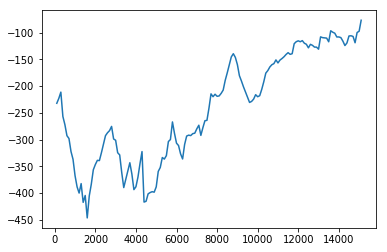

In [18]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key= lambda k: k))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [19]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-12-07 22:42:05,673] Making new env: LunarLander-v2
[2017-12-07 22:42:05,676] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-07 22:42:05,681] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.152.24307.video000000.mp4

[2017-12-07 22:42:21,264] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.152.24307.video000001.mp4



Episode finished after 979 timesteps with reward=101.16474960983258
Episode finished after 1000 timesteps with reward=-113.71548057862304
Episode finished after 1000 timesteps with reward=-124.71434612958552
Episode finished after 1000 timesteps with reward=-98.29424030985575
Episode finished after 1000 timesteps with reward=-131.45069745544023
Episode finished after 1000 timesteps with reward=-80.21136790781634
Episode finished after 1000 timesteps with reward=-88.68219603087408


[2017-12-07 22:42:53,796] Starting new video recorder writing to /home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records/openaigym.video.152.24307.video000008.mp4



Episode finished after 243 timesteps with reward=-75.77562954918943
Episode finished after 1000 timesteps with reward=-151.1553398895244


[2017-12-07 22:43:11,800] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/anatoly/ML/Ml-mipt/Ml-mipt/2_semester/hw-5/records')


Episode finished after 1000 timesteps with reward=-74.85949422539721
average reward: [101.16474960983258, -113.71548057862304, -124.71434612958552, -98.294240309855752, -131.45069745544023, -80.211367907816339, -88.682196030874081, -75.775629549189432, -151.15533988952441, -74.859494225397214]
